In [1]:

import datetime
import os
import cv2
import glob
import h5py
import sys
import optparse
import copy
import re 
import json

import pylab as pl
from collections import Counter
import seaborn as sns
import cPickle as pkl
import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns
import tifffile as tf

from pipeline.python.classifications import test_responsivity as resp #import calculate_roi_responsivity, group_roidata_stimresponse, find_barval_index
#from pipeline.python.classifications import osi_dsi as osi
from pipeline.python.utils import natural_keys, label_figure

from pipeline.python.retinotopy import fit_2d_rfs as rf

from pipeline.python.utils import uint16_to_RGB
from skimage import exposure
from matplotlib import patches

from scipy import stats
from scipy.interpolate import interp1d
import scipy.optimize as spopt

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/test_responsivity.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    

In [2]:
%matplotlib notebook

In [3]:
def load_run_data(animalid, session, fov, run, trace_type='dff',
                  traceid='traces001', rootdir='/n/coxfs01/2p-data'):
    
    data_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, run, \
                                           'traces', '%s*' % traceid, 'data_arrays', 'datasets.npz'))[0]
    print("[%s]...loading data array (%s)" % (run, traceid))
    dset = np.load(data_fpath)
    traces = dset[trace_type]
    labels = pd.DataFrame(data=dset['labels_data'], columns=dset['labels_columns'])
    sdf = pd.DataFrame(dset['sconfigs'][()]).T
    return traces, labels, sdf
    

In [4]:
class Struct():
    pass

def get_roi_id(animalid, session, fov, run, traceid, rootdir='/n/coxfs01/2p-data'):
    traceid_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s*' % run, \
                                         'traces', 'traceids_*.json'))[0] # % traceid, ))
    with open(traceid_fpath, 'r') as f:
        traceids = json.load(f)
    return traceids[traceid]['PARAMS']['roi_id']

class Experiment():
    def __init__(self, experiment_type, animalid, session, fov, traceid='traces001', trace_type='corrected'):
        self.name = experiment_type
        self.animalid = animalid
        self.session = session
        self.fov = fov
        self.traceid = traceid
        self.trace_type = trace_type
        self.rois = get_roi_id(animalid, session, fov, experiment_type, traceid, rootdir=rootdir)
        self.source =  self.get_data_paths(rootdir=rootdir)
        self.data = self.load()
        
                
    def load(self):
        data = Struct()
        assert os.path.exists(self.source), "File path does not exist! -- %s" % self.source
        if self.source.endswith('npz'):
            dset = np.load(self.source)
            print("[%s]...loading data array\n(%s)" % (self.name, self.source))
            data.traces  = dset[self.trace_type]
            data.labels = pd.DataFrame(data=dset['labels_data'], columns=dset['labels_columns'])
            data.sdf = pd.DataFrame(dset['sconfigs'][()]).T
            data.info = dset['run_info'][()]
        else:
            print("*** NOT IMPLEMENTED ***\n--%s--" % self.source)
        #elif self.source.endswith('h5'):
        #    data = h5py.File(fpath, 'r')
            # TODO: formatt retino data in sensible way with rutils
            
        return data
    
#     def get_run_list(self, rootdir='/n/coxfs01/2p-data'):
#         fov_dir = os.path.join(rootdir, self.animalid, self.session, self.fov)
#         all_runs = glob.glob(os.path.join(fov_dir, '*run*'))
#         combined_runs = glob.glob(os.path.join(fov_dir, '*combined*'))
#         single_runs = []
#         for crun in combined_runs:
#             stim_type = re.search('combined_(.+?)_static', os.path.split(crun)[-1]).group(1)
#             print stim_type
#             single_runs.extend(glob.glob(os.path.join(fov_dir, '%s_run*' % stim_type)))
#         extracted_runs = [r for r in all_runs if r not in single_runs and 'compare' not in r]
#         extracted_runs.extend(combined_runs)
        
#         return extracted_runs
            
    def get_data_paths(self, rootdir='/n/coxfs01/2p-data'):
        fov_dir = os.path.join(rootdir, self.animalid, self.session, self.fov)
        all_runs = glob.glob(os.path.join(fov_dir, '*%s*' % self.name))
        combined_runs = [r for r in all_runs if 'combined' in r]
        single_runs = []
        for crun in combined_runs:
            stim_type = re.search('combined_(.+?)_static', os.path.split(crun)[-1]).group(1)
            print stim_type
            single_runs.extend(glob.glob(os.path.join(fov_dir, '%s_run*' % stim_type)))
        run_list = [r for r in all_runs if r not in single_runs and 'compare' not in r]

        data_fpaths = []
        for run_dir in run_list:
            run_name = os.path.split(run_dir)[-1]
            print("[%s] ... getting data path." % run_name)
            try:
                if 'retino' in run_dir:
                    fpath = glob.glob(os.path.join(run_dir, 'traces', 'extracted_traces.h5'))[0]
                else:
                    fpath = glob.glob(os.path.join(run_dir, 'traces', '%s*' % self.traceid, \
                                                   'data_arrays', 'datasets.npz'))[0]
                data_fpaths.append(fpath)
                
            except IndexError:
                print("... no data arrays found for: %s" % run_name)
        if len(data_fpaths) > 1:
            print("More than 1 file found for %s" % self.name)
            for fi, fpath in enumerate(data_fpaths):
                print fi, fpath
            sel = input("Select IDX of file path to use: ")
            data_fpath = data_fpaths[int(sel)]
        else:
            data_fpath = data_fpaths[0]
        
        corresp_run_name = os.path.split(data_fpath.split('/traces/')[0])[-1]
        if self.name != corresp_run_name:
            print("Renaming experiment to run name: %s" % corresp_run_name)
            self.name = corresp_run_name

        return data_fpath



# Load dataset

In [5]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' 
session = '20190522' #'20190319'
fov = 'FOV1_zoom2p0x' 
rfs_run = 'combined_rfs_static'
gratings_run = 'combined_gratings_static'
blobs_run = 'combined_blobs_static'
traceid = 'traces001' #'traces002'

fov_dir = os.path.join(rootdir, animalid, session, fov)
# data_identifier = '|'.join([animalid, session, fov, run, traceid])

# create_new=True
# n_processes=1

In [6]:
# Create common output dir:
output_dir = os.path.join(rootdir, animalid, session, fov, 'compare_runs')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Common output dir: %s" % output_dir)

Common output dir: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/compare_runs


##### Load RF fits

In [46]:
rf_response_metric = 'snr'
rf_response_thr = 1.5
rf_fit_str = 'rfs_2dgaus_responsemin_%s%.2f_no_trim_' % (rf_response_metric, rf_response_thr)
rf_fit_thr = 0.5
print("RFs: %s" % rf_fit_str)

sigma_scale = 2.35

RFs: rfs_2dgaus_responsemin_snr1.50_no_trim_


In [8]:
rfs_datapath =  glob.glob(os.path.join(rootdir, animalid, session, fov, rfs_run, \
                                       'traces', '%s*' % traceid, 'figures', 'receptive_fields',
                                       '%s*' % rf_fit_str, '*.pkl'))[0]
print("...loading RF fit data...")
with open(rfs_datapath, 'rb') as f:
    rf_fits = pkl.load(f)


...loading RF fit data...


In [9]:
rfs_rois = [roi for roi, rf_fit in rf_fits['fits'].items() if rf_fit['r2'] >= rf_fit_thr]
print("%i rois have RF fits with thr >= %.2f" % (len(rfs_rois), rf_fit_thr))

64 rois have RF fits with thr >= 0.50


##### Load gratings dataset

In [10]:
gratings = Experiment('gratings', animalid, session, fov, traceid, trace_type='dff')


gratings
[combined_gratings_static] ... getting data path.
[mean_Slice01_Channel01_File001_gratings1.png] ... getting data path.
... no data arrays found for: mean_Slice01_Channel01_File001_gratings1.png
[max_std_Slice01_Channel01_gratings.png] ... getting data path.
... no data arrays found for: max_std_Slice01_Channel01_gratings.png
Renaming experiment to run name: combined_gratings_static
[combined_gratings_static]...loading data array
(/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/data_arrays/datasets.npz)


In [11]:
#gdf = resp.get_roi_trial_response(dff_traces, labels)
gdf = resp.group_roidata_stimresponse(gratings.data.traces, gratings.data.labels)
nrois_total = len(gdf.groups)


In [12]:
# roi = 163
# best_cfg = gdf.get_group(roi).groupby(['config']).mean()[metric_type].idxmax()
# best_cfg_params = gratings_params.loc[best_cfg][[p for p in params if p!='ori']]
# curr_cfgs = sorted([c for c in gratings_params.index.tolist() \
#                     if all(gratings_params.loc[c][[p for p in params if p!='ori']] == best_cfg_params)],\
#                     key = lambda x: gratings_params['ori'][x])

NameError: name 'metric_type' is not defined

In [13]:
# gdf.get_group(163).groupby(['config']).mean().loc[curr_cfgs]

In [14]:
# response_type = 'meanstim'
# #mean_responses = roi_df.groupby(['config']).mean()[response_type]
# mean_responses = roi_df.groupby(['config']).mean()['meanstim'] / roi_df.groupby(['config']).mean()['base_mean']
# sem_responses = roi_df.groupby(['config']).sem()[response_type]
# sorted_config_ixs = mean_responses.values.argsort()[::-1]
# sorted_configs = [mean_responses.index[s] for s in sorted_config_ixs]

# constant_params = ['aspect', 'luminance', 'position', 'stimtype']
# params = [c for c in sdf.columns if c not in constant_params]
# stimdf = sdf[params]

# best_cfg = sorted_configs[0]
# best_cfg_params = stimdf.loc[best_cfg][[p for p in params if p!='ori']]
# curr_cfgs = sorted([c for c in stimdf.index.tolist() \
#                     if all(stimdf.loc[c][[p for p in params if p!='ori']] == best_cfg_params)],\
#                     key = lambda x: stimdf['ori'][x])

In [15]:
# meanr = roi_df[roi_df['config'].isin(curr_cfgs)].groupby('config').mean()
# meanr

In [16]:
# meanr2 = roi_df[roi_df['config'].isin(curr_cfgs)].groupby('config').mean()
# meanr2['zscore'] = (meanr2['meanstim'] - meanr2['base_mean']) / meanr2['base_std']
# meanr2['snr'] = meanr2['meanstim'] / meanr2['base_mean']
# meanr2

In [17]:
# fig, ax = pl.subplots()
# ax.plot(meanr['meanstim'])
# ax.set_xticklabels([sdf['ori'][c] for c in curr_cfgs])

In [48]:
response_type = 'meanstim'
response_thr = 0.1
goodness_type = 'zscore' #['zscore', 'snr']
goodness_thr = 1.1 # [1.5, 1.5]
trace_type = 'dff'
metric_type = 'zscore'


interp_interval = 3

gratings_rois = [k for k, g in gdf if g.groupby(['config']).mean()[response_type].max() >= response_thr\
            and g.groupby(['config']).mean()[goodness_type].max() >= goodness_thr ]
print("%i out of %i cells meet min %s req. of %.2f" % (len(gratings_rois), nrois_total, response_type, response_thr))

#goodness_str = '_'.join(['%s%.2f' % (gt, gthr) for gt, gthr in zip(goodness_type, goodness_thr)])

tuning_fit_str = 'fit_%s__%s_responsemin_%s%.2f_goodness_%s%.2f' % (metric_type, trace_type, \
                                                             response_type, response_thr, \
                                                             goodness_type, goodness_thr)
print(tuning_fit_str)

#gdf.get_group(201).groupby(['config']).mean()[response_type].max()


51 out of 260 cells meet min meanstim req. of 0.10
fit_zscore__dff_responsemin_meanstim0.10_goodness_zscore1.10


In [19]:
from pipeline.python.classifications import osi_dsi as osi

In [20]:
reload(osi)

<module 'pipeline.python.classifications.osi_dsi' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/osi_dsi.pyc'>

In [21]:
tuning_fpath = glob.glob(os.path.join(fov_dir, '*%s*' % gratings.name, \
                                      'traces', '%s*' % traceid, 
                                      'tuning', '%s' % tuning_fit_str, 'roistats*.pkl'))
print(tuning_fpath)
refit_tuning = False

tuning_fits, tuning_df = osi.calculate_gratings_stats(animalid, session, fov, gratings.name, traceid,
                                             trace_type=gratings.trace_type, metric_type=metric_type,
                                             response_type=response_type, response_thr=response_thr,
                                             goodness_type=goodness_type, goodness_thr=goodness_thr, 
                                           create_new=refit_tuning)
print(tuning_df.shape)

['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/fit_zscore__dff_responsemin_meanstim0.10_goodness_zscore1.10/roistats.pkl']
51 out of 260 cells meet min meanstim req. of 0.10
Saving roi fits to: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/tuning/fit_zscore__dff_responsemin_meanstim0.10_goodness_zscore1.10
Loading existing results...
(51, 7)


In [22]:
rfs_gratings_rois = [r for r in rfs_rois if r in gratings_rois]
print(len(rfs_gratings_rois))

21


In [23]:

tuning_thr = 0.7
tdf = tuning_df[((tuning_df['roi'].isin(rfs_gratings_rois)) & (tuning_df['r2']>=tuning_thr))]
print(tdf.shape)
tdf

(14, 7)


,DSI,DSI_cv,OSI,OSI_cv,pref_ori,r2,roi
7,0.233667,0.256716,0.516624,0.085240,90.0,0.951174,144
8,0.282667,0.281271,0.352626,0.159373,45.0,0.931391,17
9,0.090748,0.220984,0.256866,0.226933,0.0,0.868960,147
10,0.251334,0.123117,0.250483,0.155443,180.0,0.920962,148
12,0.487444,0.333542,0.607826,0.074798,90.0,0.971795,151
13,0.020466,0.291502,0.605253,0.177480,270.0,0.872130,25
15,0.795566,0.626923,0.865590,0.461451,270.0,0.985746,30
18,0.297262,0.343443,0.618924,0.209939,270.0,0.917594,163
24,0.166518,0.167085,0.283117,0.136812,180.0,0.853771,59
26,0.176661,0.278826,0.650592,0.131549,225.0,0.913799,67


<IPython.core.display.Javascript object>


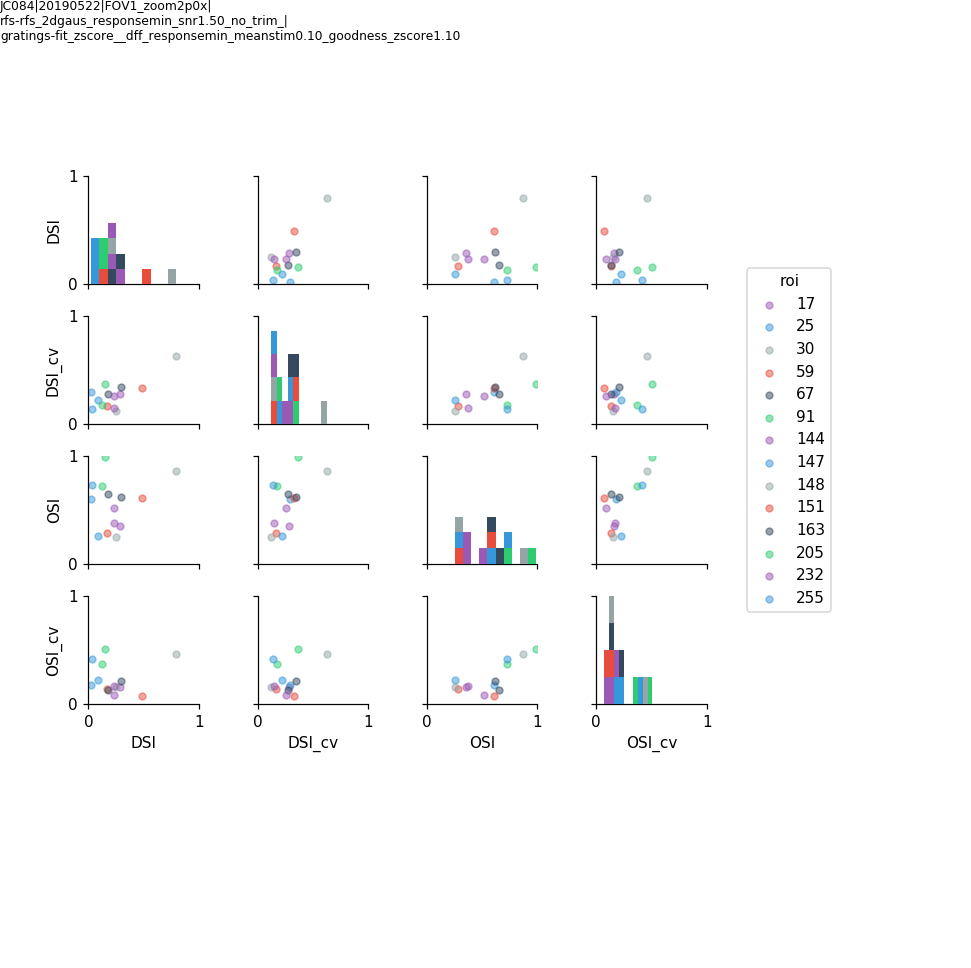

Saved:
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/compare_runs/distN_tuning_metrics__rois_fit__rfs_gratings_thr_0.70.png


In [24]:
palette = sns.color_palette()

g = sns.PairGrid(tdf, hue='roi', vars=['DSI', 'DSI_cv', 'OSI', 'OSI_cv'], 
                 size=2, aspect=1, palette=palette)
g = g.map_offdiag(pl.scatter, marker='o',  alpha=0.5, s=20)

g = g.map_diag(pl.hist, normed=True) #histtype="step",  
#sns.distplot, kde=False, hist=True, rug=True,\
               #hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1.0})
    
g = g.add_legend(bbox_to_anchor=(0.95,.5))

pl.subplots_adjust(left=0.1, right=0.8, top=0.8, bottom=0.2)

g.set(xlim=(0,1), ylim=(0,1))
g.set(xticks=[0, 1])
g.set(yticks=[0, 1])
sns.despine(trim=True)

osi.cleanup_axes(g.axes[:, 1:].flat, which_axis='y')
osi.cleanup_axes( g.axes[:-1, :].flat, which_axis='x')

curr_data_id = '|'.join([animalid, session, fov, '\nrfs-%s' % rf_fit_str, '\ngratings-%s' % tuning_fit_str])
label_figure(g.fig, curr_data_id)

figname = 'distN_tuning_metrics__rois_fit__rfs_gratings_thr_%.2f' % tuning_thr
pl.savefig(os.path.join(output_dir, '%s.png' % figname))
#pl.close()
print("Saved:\n%s" % os.path.join(output_dir, '%s.png' % figname))


#### Load object data

In [25]:
blobs = Experiment('blobs', animalid, session, fov, traceid, trace_type='dff')

blobs
[combined_blobs_static] ... getting data path.
Renaming experiment to run name: combined_blobs_static
[combined_blobs_static]...loading data array
(/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/data_arrays/datasets.npz)


In [26]:
round_sz = [int(round(s)) if s is not None else s for s in blobs.data.sdf['size']]
blobs.data.sdf['size'] = round_sz


In [27]:
morphlevels = sorted(blobs.data.sdf['morphlevel'].unique())
sizes = sorted(blobs.data.sdf['size'].unique())
print morphlevels
print sizes

[-1, 0, 14, 27, 40, 53, 66, 79, 92, 106]
[nan, 10.0, 20.0, 30.0, 40.0, 50.0]


In [28]:

fr = 44.65 #dset['run_info'][()]['framerate']
nframes_on = blobs.data.labels['nframes_on'].unique()[0]
stim_on_frame = blobs.data.labels['stim_on_frame'].unique()[0]


In [29]:
import matplotlib as mpl

import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    
    if base_cmap is None:
        base = pl.cm.get_cmap('cubehelix')
    else:
        base = base_cmap
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


##### format blob data

In [30]:
bdf = resp.group_roidata_stimresponse(blobs.data.traces, blobs.data.labels)


In [31]:
print rfs_gratings_rois

[11, 17, 25, 30, 59, 67, 69, 75, 91, 143, 144, 147, 148, 150, 151, 163, 205, 231, 232, 234, 255]


In [32]:
tracedf_blobs = pd.DataFrame(blobs.data.traces)
df = blobs.data.labels.copy()

##### Look at 1 roi

In [33]:
# roi = 17



# df[trace_type] = tracedf_blobs[roi]
# df.head()

In [35]:
# btraces = {}
# for cfg, g in df.groupby(['config']):
#     btraces[cfg] = np.nanmean(np.array(list(g.groupby(['trial'])['dff'].apply(np.array))), axis=0)
# btraces = pd.DataFrame(btraces)

In [36]:
blobs.data.sdf['morphlevel'].unique()

array([-1, 0, 14, 27, 40, 53, 66, 79, 92, 106], dtype=object)

In [37]:
stimulus_dir = '/home/julianarhee/Repositories/protocols/physiology/stimuli/images'
object_list = ['D1', 'M14', 'M27', 'M40', 'M53', 'M66', 'M79', 'M92', 'D2', 'control']
image_paths = []
for obj in object_list:
    if obj == 'control':
        continue
    stimulus_type = 'Blob_%s_Rot_y_fine' % obj
    image_paths.extend(glob.glob(os.path.join(stimulus_dir, stimulus_type, '*_y0.png')))
print("%i images found for %i objects" % (len(image_paths), len(object_list)))
for i in object_list:
    print i

9 images found for 10 objects
D1
M14
M27
M40
M53
M66
M79
M92
D2
control


In [38]:
constant_params = ['aspect', 'luminance', 'position', 'stimtype']
params = [c for c in gratings.data.sdf.columns if c not in constant_params]
gratings_params = gratings.data.sdf[params]



In [39]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


In [40]:
roi_figdir = os.path.join(output_dir, 'roi_figures')
if not os.path.exists(roi_figdir):
    os.makedirs(roi_figdir)
print("Saving roi plots to:\n%s" % roi_figdir)

Saving roi plots to:
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/compare_runs/roi_figures


In [41]:
from matplotlib.patches import Ellipse, Rectangle


In [42]:
roi = 205
df[trace_type] = tracedf_blobs[roi]
df.head()

itercolors=iter(mpl.cm.cubehelix(np.linspace(0, .9, len(object_list)+1)))
scale_bar = 0.1
scale_bar2 = 0.2
lw = 1
markersize=2
markeredgewidth = 0.2
marker = 'o'
fit_color = 'gray'
tick_fontsize = 8
axis_fontsize = 10
tick_length = 2

nr = 18 #len(object_list)
nc = len(object_list)*2


fig = pl.figure(figsize=(10, 5), facecolor='w')
fig.patch.set_alpha(1)  # solution

# 1. Plot RF map -----------------------------------------------------------
rfmap_span = 8
ax0 = pl.subplot2grid((nr, nc), (0, 0), rowspan=rfmap_span-2, colspan=rfmap_span)
rfmap = rf_fits['fits'][roi]['data']
rfim = ax0.imshow(rfmap, cmap='bone', vmin=0, vmax=rfmap.max(), \
                   origin='upper')
ax0.axis('off')
ax0.set_title('roi %i' % int(roi+1))
# -- plot fit --
amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f = rf_fits['fits'][roi]['fit_r']['popt']
ell = Ellipse((x0_f, y0_f), abs(sigx_f)*sigma_scale, abs(sigy_f)*sigma_scale,\
                  angle=np.rad2deg(theta_f), alpha=1, edgecolor=fit_color, lw=1.5,\
                  facecolor='none')
ax0.add_patch(ell)
ax0.invert_yaxis()
# -- colorbar --
ax0_div = make_axes_locatable(ax0)
cax0 = ax0_div.append_axes("right", size="2%", pad="2%")
cb = colorbar(rfim, cax=cax0, orientation="vertical")
cax0.yaxis.set_ticks_position("right")
cax0.yaxis.set_tick_params(labelsize=tick_fontsize, length=0, width=0, pad=0.7)
cax0.set_yticks([0, round(rfmap.max(), 1)])
cax0.set_title('%s' % rf_fits['fit_params']['metric'], fontsize=axis_fontsize)


# 2. Plot gratings traces -----------------------------------------------------------
gratings_ix = rfmap_span
g_rowspan = 3

best_cfg = gdf.get_group(roi).groupby(['config']).mean()[metric_type].idxmax()
best_cfg_params = gratings_params.loc[best_cfg][[p for p in params if p!='ori']]
curr_cfgs = sorted([c for c in gratings_params.index.tolist() \
                    if all(gratings_params.loc[c][[p for p in params if p!='ori']] == best_cfg_params)],\
                    key = lambda x: gratings_params['ori'][x])
gmean, gstd, gtsec = osi.get_mean_and_std_traces(roi, pd.DataFrame(gratings.data.traces), \
                                                gratings.data.labels, \
                                                curr_cfgs,\
                                                gratings_params)
g_stimon = gratings.data.labels['stim_on_frame'].unique()[0]
g_nframes_on = gratings.data.labels['nframes_on'].unique()[0]
ymin = (gmean - gstd ).min()
ymax = (gmean + gstd ).max()
for icfg in range(len(curr_cfgs)):
    ax = pl.subplot2grid((nr, nc), (0, icfg+gratings_ix), \
                         colspan=1, rowspan=g_rowspan) 
    if icfg==0:
        xoffset = 0
    else:
        xoffset = 0
    ax.plot(gtsec-xoffset, gmean[icfg, :], color='k', lw=lw)

    sem_plus = np.array(gmean[icfg,:]) + np.array(gstd[icfg,:])
    sem_minus = np.array(gmean[icfg,:]) - np.array(gstd[icfg,:])
    ax.fill_between(gtsec-xoffset, sem_plus, y2=sem_minus, alpha=0.2, color='k')

    # -- aesthetics --
    ax.set_xticks([]); ax.set_xticklabels([]);
    #ax.set_xticks([gtsec[g_stimon], round(gtsec[g_stimon+g_nframes_on], 1)])
    #ax.set_xticklabels(['%.2f s' % round(gtsec[g_stimon+g_nframes_on], 1), ''])
    ax.xaxis.set_tick_params(rotation=0, labelsize=tick_fontsize,\
                             length=2, width=1, pad=0.7)
    ax.yaxis.set_tick_params(rotation=0, labelsize=tick_fontsize,\
                             length=tick_length, width=1, pad=0.7)
    ax.set_yticks([gmean[0].mean(), gmean[0].mean()+scale_bar])
    ax.set_yticklabels(['', '%i%%\ndf/f' % (scale_bar*100)])
    ax.set_ylim([ymin, ymax])
    if icfg > 0:
        ax.set_yticks([]); ax.set_yticklabels([]);
        ax.set_xticks([]); ax.set_xticklabels([]);
        sns.despine(ax=ax, offset=4, trim=True, left=True, bottom=True)
    else:
        #ax.set_ylabel('%s' % trace_type, fontsize=6); #ax.set_xlabel('time (s)', fontsize=6);
        sns.despine(ax=ax, offset=4, trim=True, bottom=True)

# 3. Plot tuning curve  -----------------------------------------------------------
tested_oris = gratings.data.sdf['ori'].unique()
meanr = gdf.get_group(roi).groupby(['config']).mean()[metric_type].loc[curr_cfgs]
semr = gdf.get_group(roi).groupby(['config']).sem()[metric_type].loc[curr_cfgs]
ax2 = pl.subplot2grid((nr, nc), (g_rowspan, gratings_ix), \
                          colspan=len(tested_oris), rowspan=g_rowspan)
# -- plot raw
ax2.plot(tested_oris, meanr, 'k', marker=marker,\
         markersize=markersize, markeredgewidth=markeredgewidth, lw=0)
ax2.errorbar(tested_oris, meanr, yerr=semr, fmt='none', ecolor='k', elinewidth=1)
# -- plot fit
ax2.plot(tuning_fits[roi]['x'][0:-interp_interval], tuning_fits[roi]['fit_y'][0:-interp_interval], \
         c=fit_color, lw=lw)
# -- aesthetics
ax2.set_xticks(tested_oris)
ax2.set_xticklabels([r'$\Uparrow$', r'$\Nearrow$', r'$\Rightarrow$', r'$\Searrow$',\
                    r'$\Downarrow$', r'$\Swarrow$', r'$\Leftarrow$', r'$\Nwarrow$'], color='k')

ax2.set_yticks([0, 1])
ax2.set_yticklabels(['', '1 stds'])
sns.despine(ax=ax2, trim=True, offset=2, bottom=True)
ax2.yaxis.set_tick_params(labelsize=tick_fontsize, length=tick_length, width=1, pad=0.7)
ax2.xaxis.set_tick_params(labelsize=axis_fontsize, length=0, width=0)
ax2.set_ylim([0, (meanr.max()+semr.max())*1.3])


# 2. Plot tuning curve polar fit -----------------------------------------------------------
polar_ix = gratings_ix + len(tested_oris)
axp = pl.subplot2grid((nr, nc), (0, polar_ix), polar=True,\
                      colspan=g_rowspan*2, rowspan=g_rowspan*2) #pl.subplots(1, 3) #pl.figure()
interp_interval=3
# -- plot raw
thetas = np.array([np.deg2rad(c) for c in tuning_fits[roi]['x'][0::interp_interval]])
radii = np.array(tuning_fits[roi]['y'][0::interp_interval])
axp.plot(thetas, radii, 'k-', lw=lw)
# -- plot fit
thetas_fit = np.array([np.deg2rad(c) for c in tuning_fits[roi]['x']])
radii_fit = np.array(tuning_fits[roi]['fit_y'])
axp.plot(thetas_fit, radii_fit, lw=lw, c=fit_color)
# -- aesthetics
axp.set_theta_zero_location("N")
axp.set_yticks([radii.min(), radii.max()])
axp.set_yticklabels(['', round(radii.max(), 1)])
axp.yaxis.set_tick_params(labelsize=tick_fontsize)
axp.xaxis.set_tick_params(labelsize=axis_fontsize, pad=0.01)




# 3. Plot object responses  -----------------------------------------------------------
morph_ix=rfmap_span
m_colspan=2
m_rowspan=4

# -- - plot images ---
testim = cv2.imread(image_paths[0])
img_dims = testim[:, :, 0].shape
for mi, morphname in enumerate(object_list):
    print morphname
    if morphname == 'control':
        ax = pl.subplot2grid((nr, nc), (morph_ix, nc-m_colspan),colspan=m_colspan)
        ax.imshow(np.random.random(img_dims), cmap='gray')
    else:
        ax = pl.subplot2grid((nr, nc), (morph_ix, (mi*m_colspan)), colspan=m_colspan) #rowspan=1)
        img = cv2.imread(image_paths[mi])
        ax.imshow(img[:, :, 0], cmap='gray')    
    #ax.set_title(morphname, fontsize=axis_fontsize)#, fontsize=6)
    ax.set_xticks([]); ax.set_xticklabels([]);
    ax.set_yticks([]); ax.set_yticklabels([]);


# -- - plot traces ---
df[trace_type] = tracedf_blobs[roi]
btraces = {}
for cfg, g in df.groupby(['config']):
    btraces[cfg] = np.nanmean(np.array(list(g.groupby(['trial'])['dff'].apply(np.array))),\
                              axis=0)
btraces = pd.DataFrame(btraces)

offset = (btraces.max().max() - btraces.min().min() ) / 2.
last_cfg = None
last_morph=None
curr_morph = None
color = next(itercolors)
aix=-1
alpha=0.4
nplots=0
for ci, cfg in enumerate(btraces.columns):
    if ci > 0:
        curr_morph = blobs.data.sdf['morphlevel'][cfg]
        last_morph = blobs.data.sdf['morphlevel'][last_cfg]
    if last_morph != curr_morph:
        alpha = 0.4
        nplots = 0

    if blobs.data.sdf['morphlevel'][cfg] == -1:
        color = 'gray'
        if last_morph is None or last_morph != curr_morph:
            ax1 = pl.subplot2grid((nr, nc), ( morph_ix+1, nc-m_colspan),\
                                  rowspan=m_rowspan, colspan=m_colspan)
            #ax1.set_xticks([]); ax1.set_xticklabels([]);
            ax1.set_xticks([stim_on_frame]); ax1.set_xticklabels([r'$\bigtriangleup$']);
            ax1.xaxis.set_tick_params(labelsize=5, \
                                      length=0, width=0, pad=0.001)
            ax1.set_yticks([]); ax1.set_yticklabels([]);
            sns.despine(left=True, bottom=True, ax=ax1)
    else:
        if ci == 0 or curr_morph!=last_morph:
            aix += 1
            color = next(itercolors)
            ax1 = pl.subplot2grid((nr, nc), (morph_ix+1, (aix*m_colspan)),\
                                  rowspan=m_rowspan, colspan=m_colspan)
            if blobs.data.sdf['morphlevel'][cfg] == 0:
                print('here')
                ax1.set_xticks([stim_on_frame, stim_on_frame+round(fr*1.0)])
                ax1.set_xticklabels([])
                ax1.set_xlabel('1s', fontsize=6)
                miny = ax1.get_ylim()[0]+offset*6
                ax1.set_yticks([miny, miny+scale_bar2])
                ax1.set_yticklabels(['', '%i%%\ndf/f' % (scale_bar2*100)])
                ax1.yaxis.set_tick_params(rotation=0, labelsize=tick_fontsize,\
                                          length=tick_length, width=1, pad=5)
                ax1.xaxis.set_tick_params(rotation=0, labelsize=tick_fontsize,\
                                          length=tick_length, width=1, pad=0.7)

                sns.despine(trim=True, ax=ax1)
            else:
                ax1.set_xticks([stim_on_frame]); ax1.set_xticklabels([r'$\bigtriangleup$']);
                ax1.xaxis.set_tick_params(labelsize=5, \
                                          length=0, width=0, pad=0.001)
                ax1.set_yticks([]); ax1.set_yticklabels([]);
                sns.despine(left=True, ax=ax1, bottom=True) #, ax=ax1)

    alpha += (nplots*0.06)
    #print aix, alpha
    ax1.plot(btraces[cfg] + ci*offset, c=color, alpha=alpha, lw=1)
    #ax1.text(0, btraces[cfg].mean()+ci*offset, '%.2f' % blobs.data.sdf['size'][cfg])
    last_cfg = cfg
    nplots += 1

#     ax1.spines['top'].set_visible(False)
#     ax1.spines['right'].set_visible(False)
#     ax1.spines['bottom'].set_visible(False)
#     ax1.spines['left'].set_visible(False)
    pl.subplots_adjust(left=0.05, hspace=0.5, wspace=0.5, top=0.8, bottom=0.001, right=0.9)

    cax = pl.axes([0.92, 0.25, 0.005, 0.12])
    bounds = np.array(sizes[1:])+5
    bounds = sorted(np.append(bounds, 5))
    cmap = mpl.cm.gray
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(cax, cmap='gray_r',
                                    norm=norm,
                                    boundaries=bounds,
                                    ticks=np.array(bounds)-5,
                                    spacing='proportional',
                                    orientation='vertical')
    cb2.ax.yaxis.set_tick_params(length=0, labelsize=tick_fontsize, width=1, pad=0.7)
    cb2.ax.set_title('size', fontsize=axis_fontsize)
    
curr_data_id = '|'.join([animalid, session, fov, '\nrfs-%s' % rf_fit_str, '\ngratings-%s' % tuning_fit_str])
label_figure(fig, curr_data_id)
    

<IPython.core.display.Javascript object>

NameError: name 'sigma_scale' is not defined

In [43]:
bounds = np.array(sizes[1:])+5

bounds

array([ 15.,  25.,  35.,  45.,  55.])

<IPython.core.display.Javascript object>


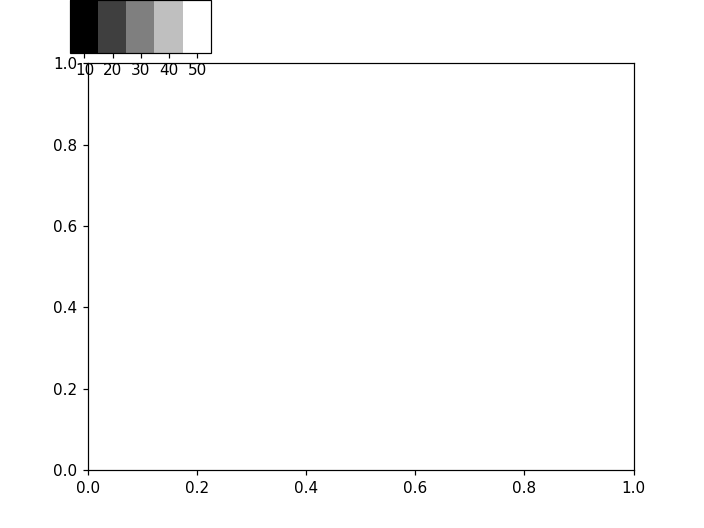

In [44]:
fig, ax = pl.subplots()

cax = pl.axes([0.1, 0.9, 0.2, 0.1])

bounds = np.array(sizes[1:])+5
bounds = sorted(np.append(bounds, 5))
cmap = mpl.cm.gray
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(cax, cmap='gray',
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.array(bounds)-5,
                                spacing='proportional',
                                orientation='horizontal')

<IPython.core.display.Javascript object>


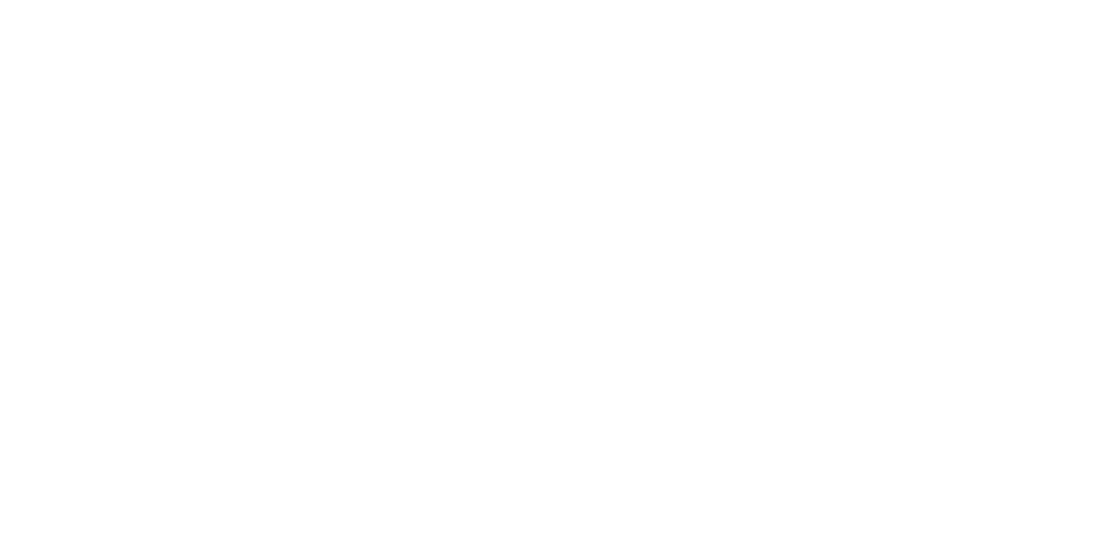

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


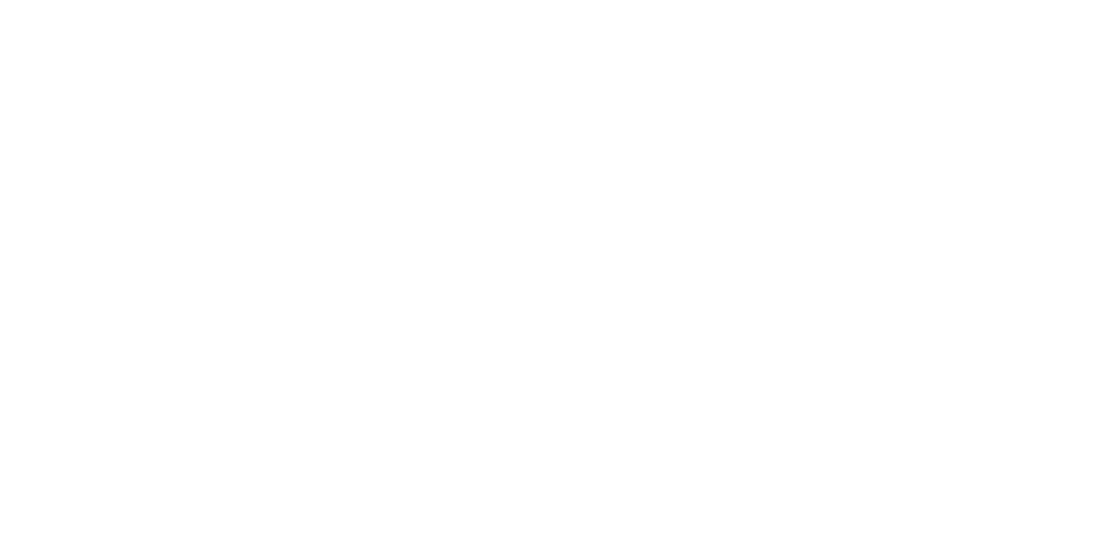

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


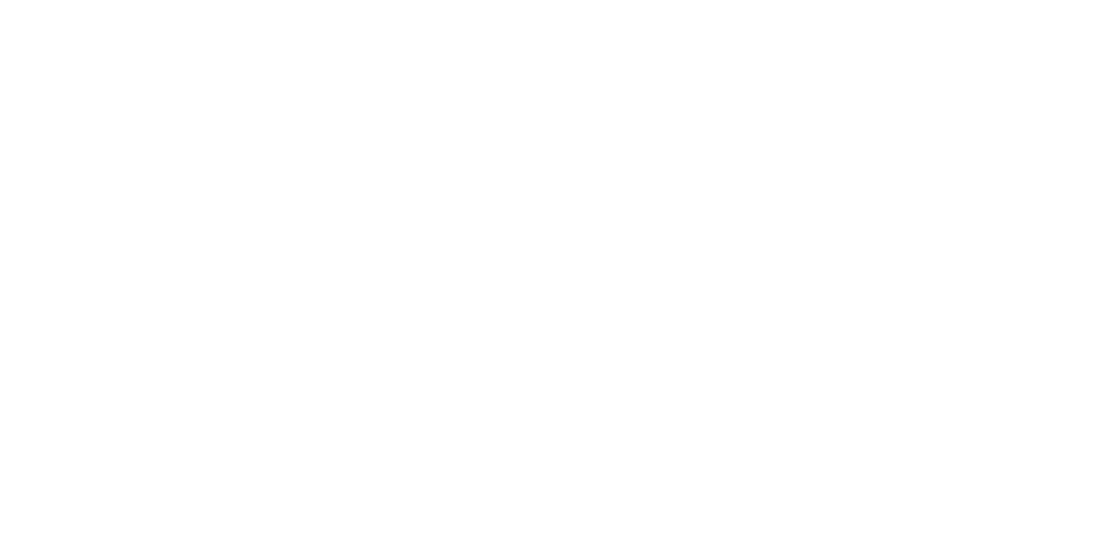

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


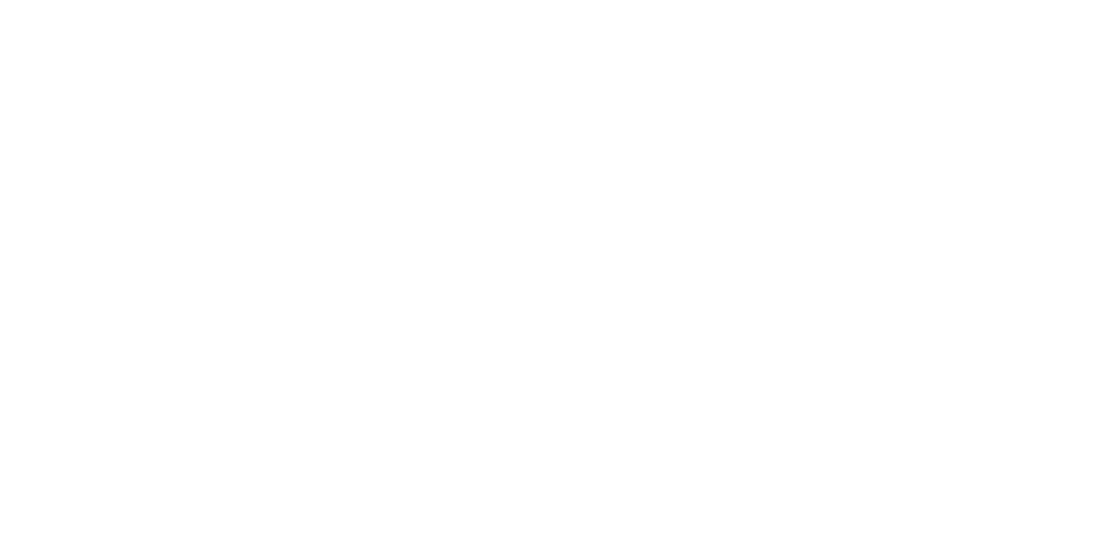

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


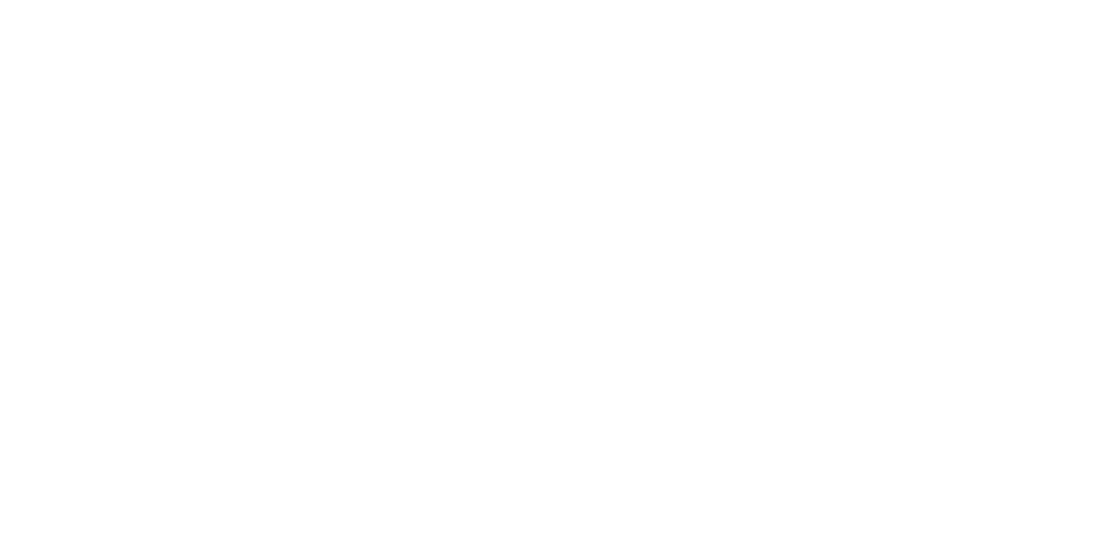

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


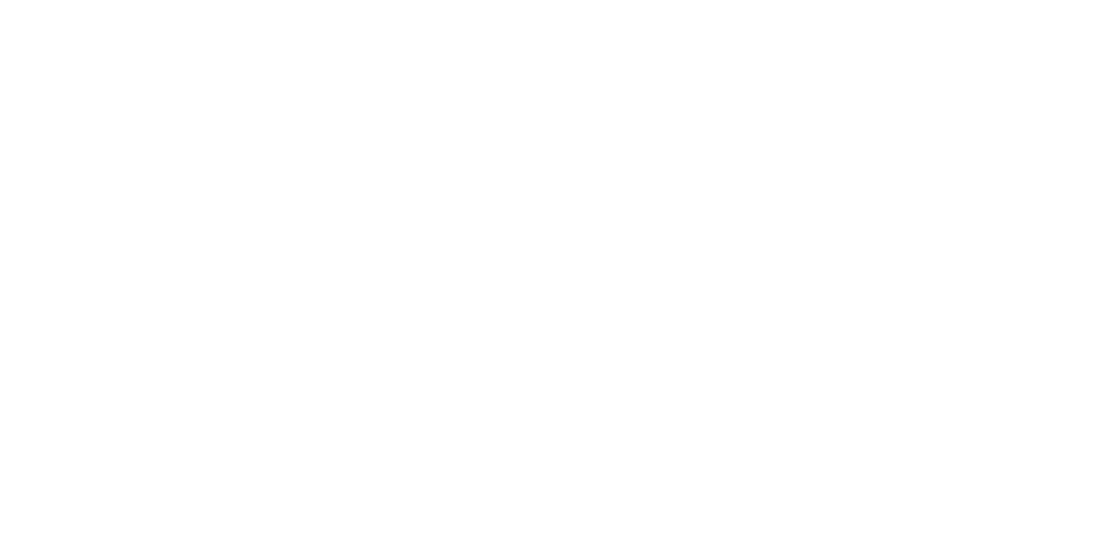

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


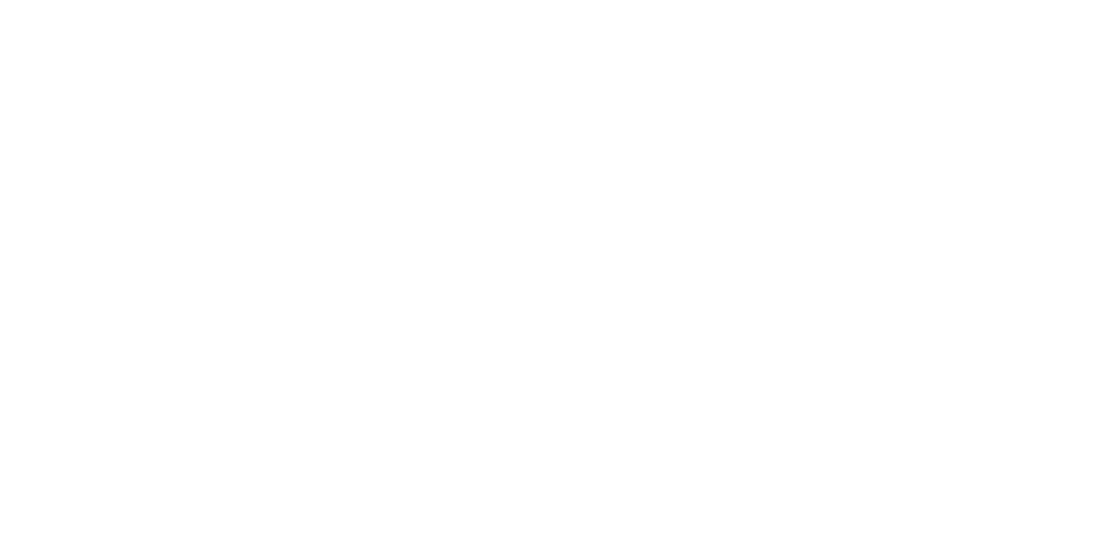

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


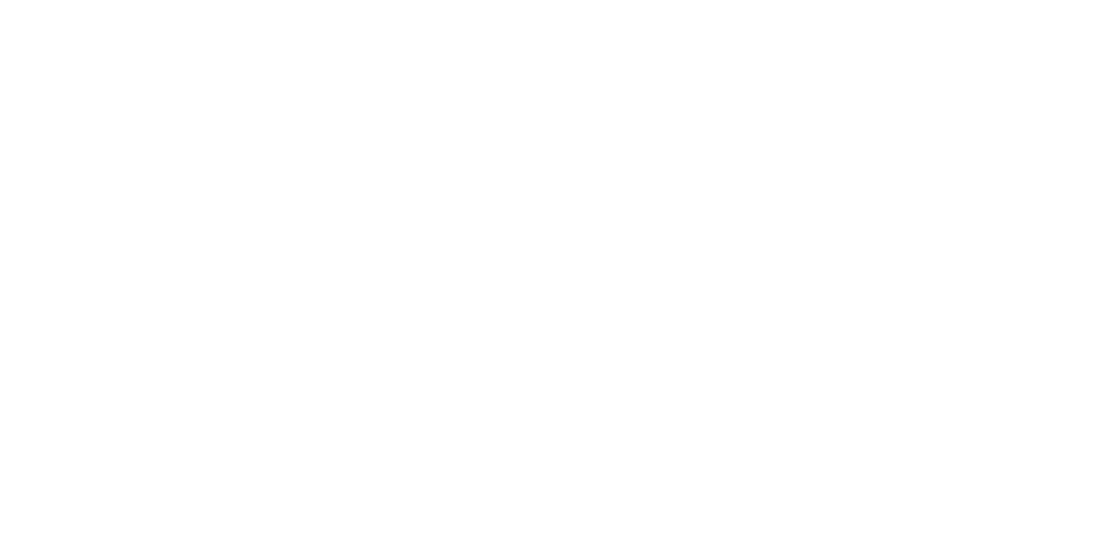

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


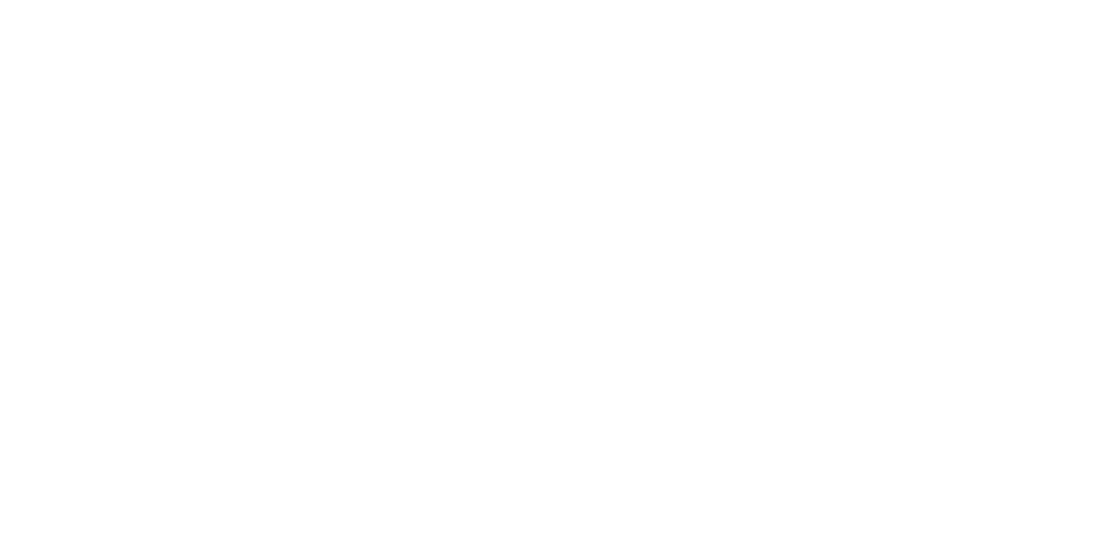

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


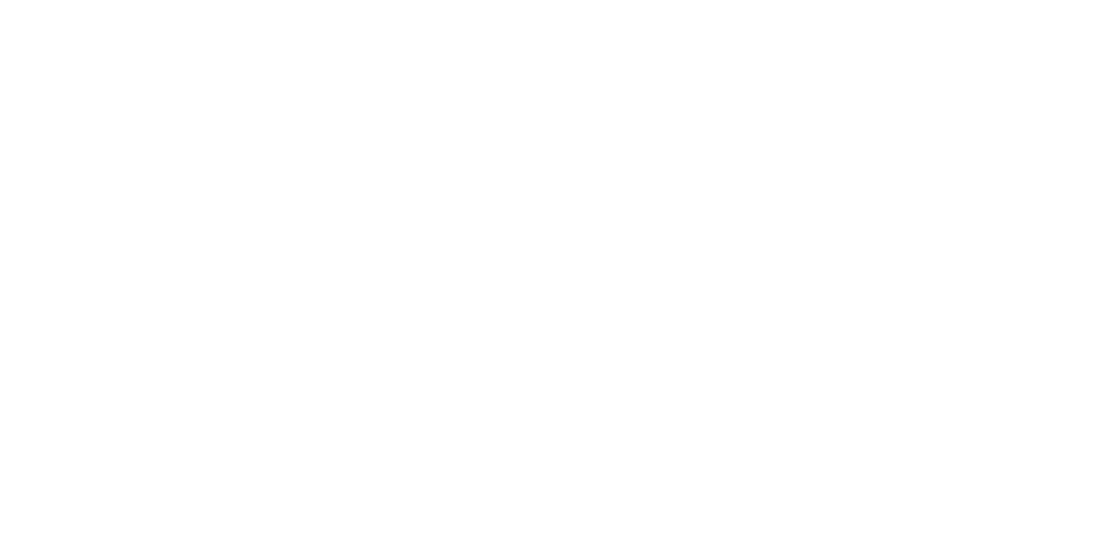

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


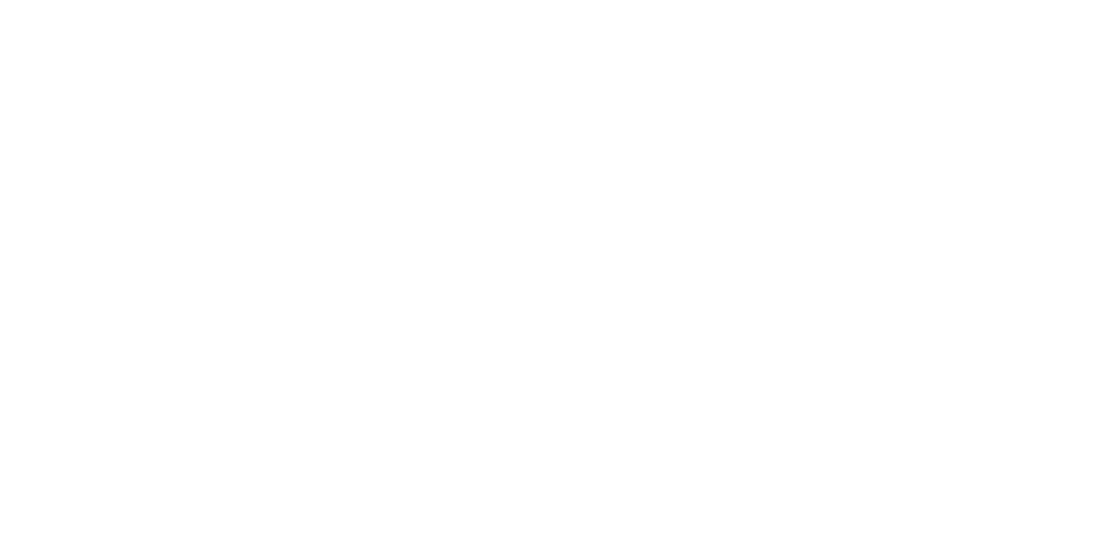

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


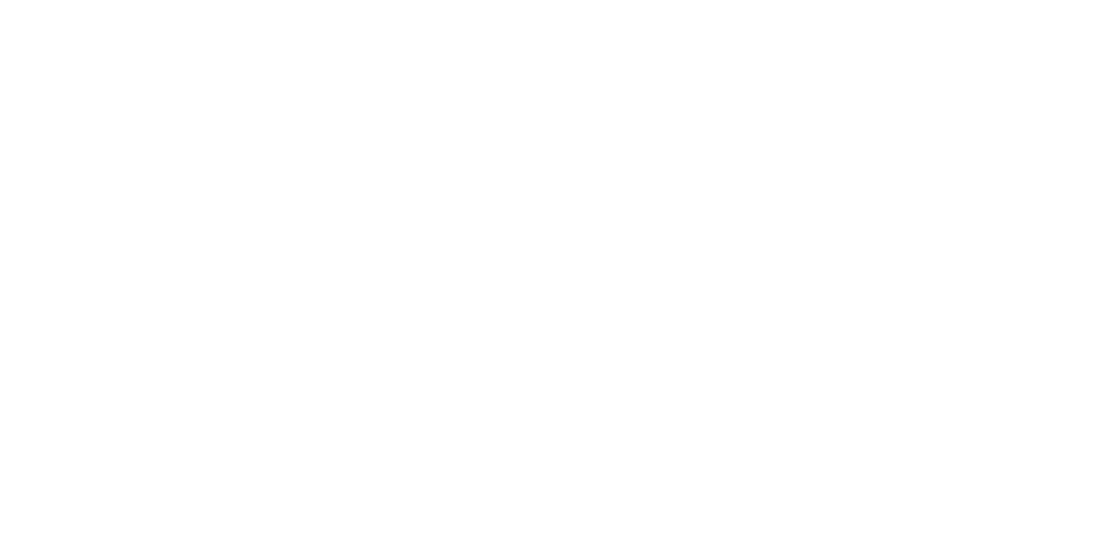

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


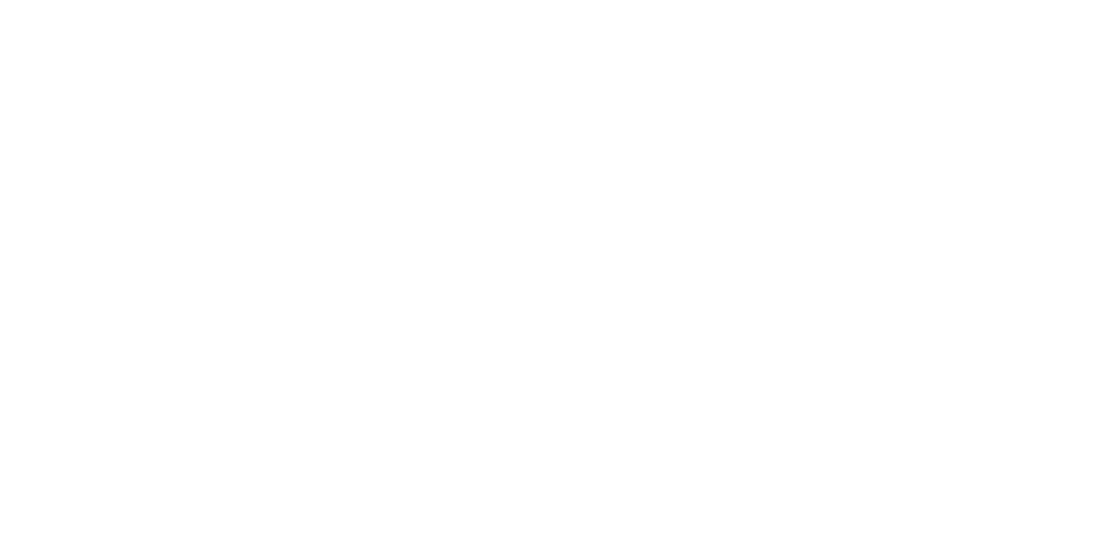

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


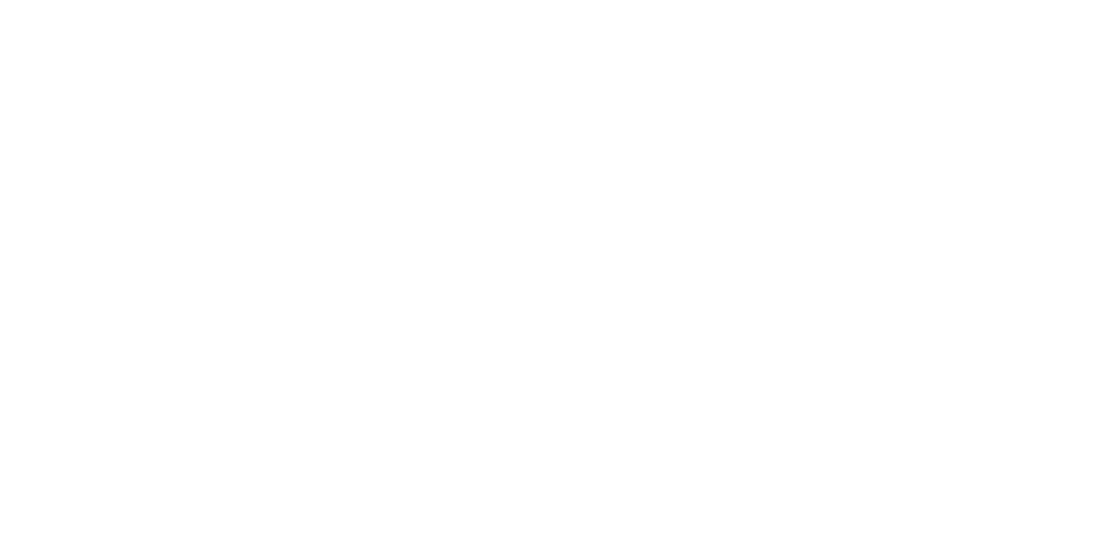

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


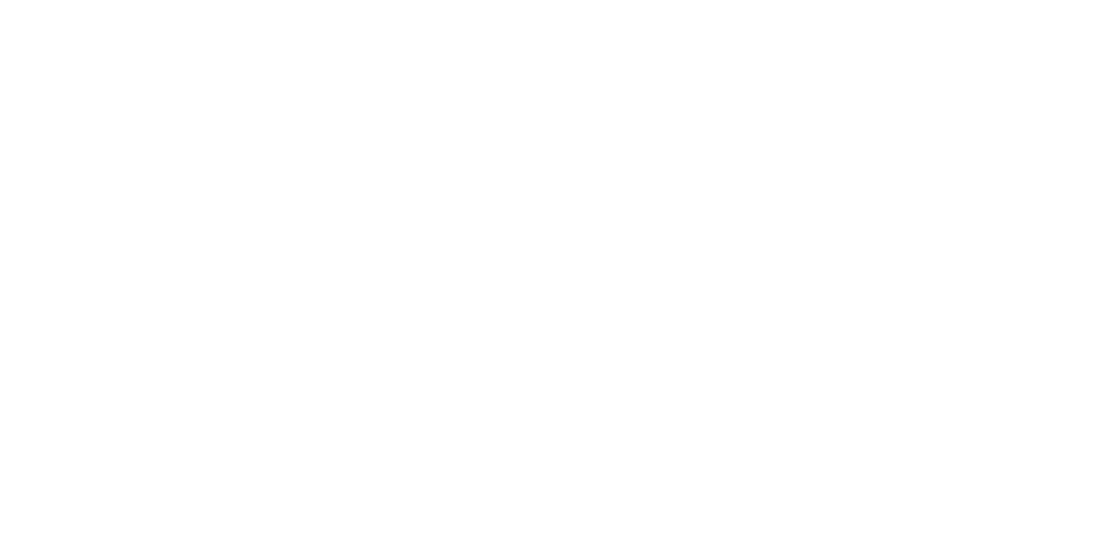

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


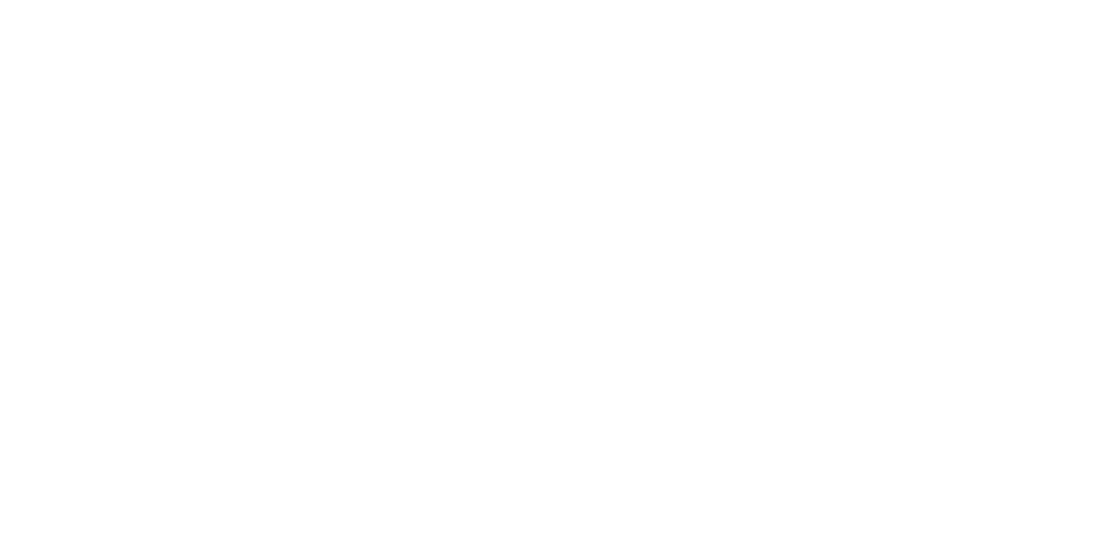

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


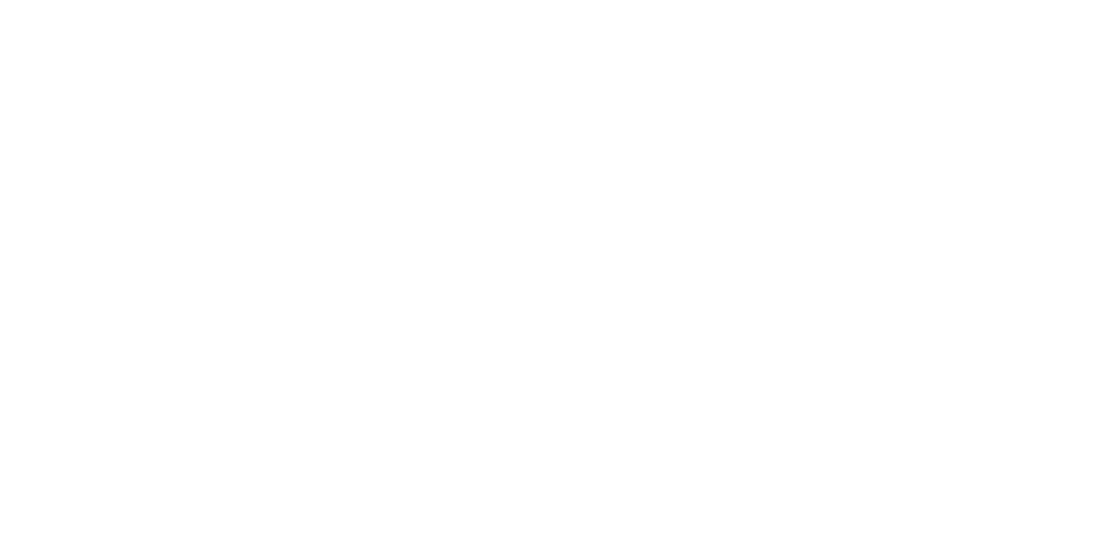

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


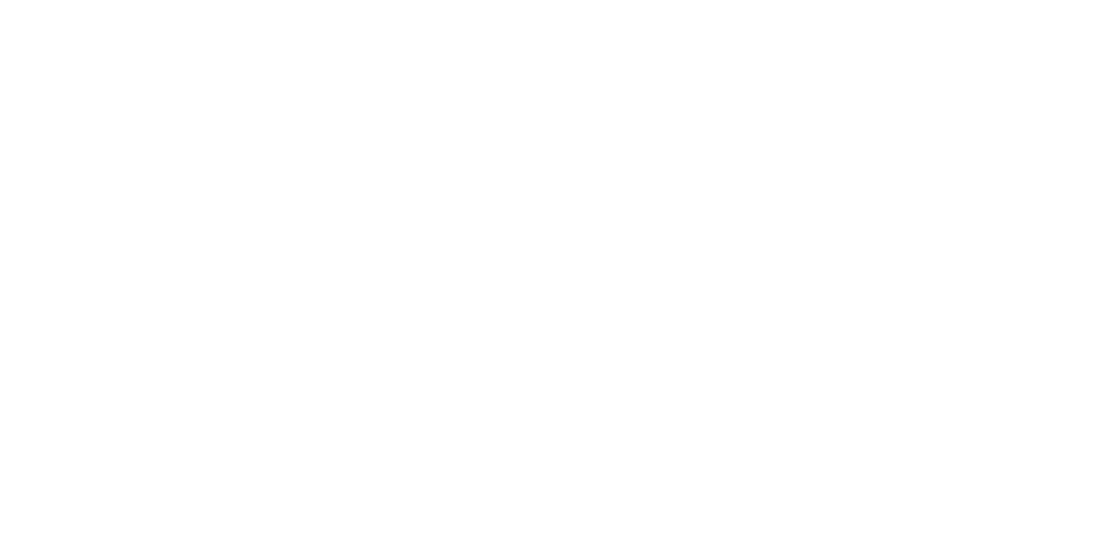

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


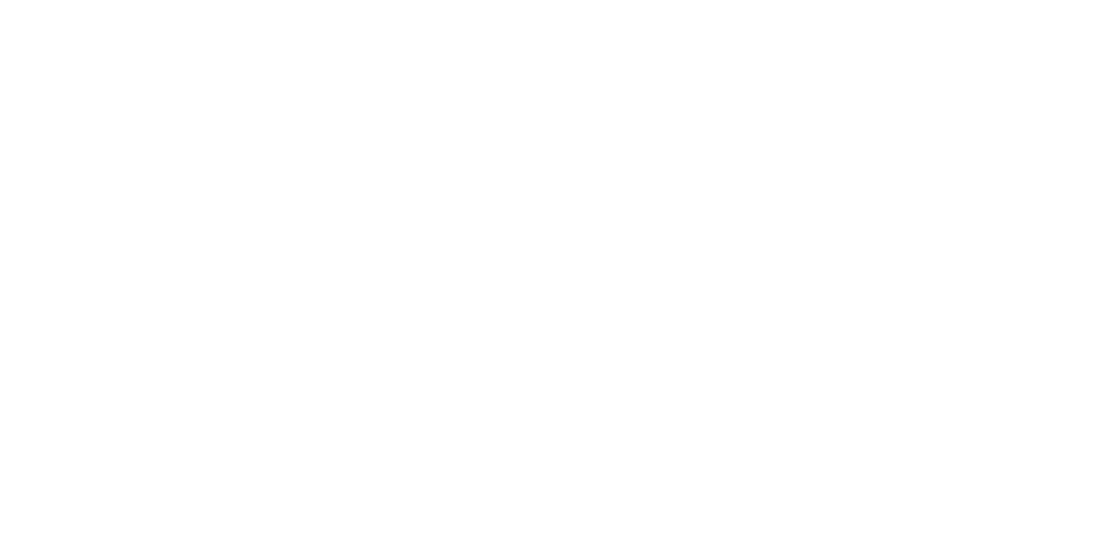

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


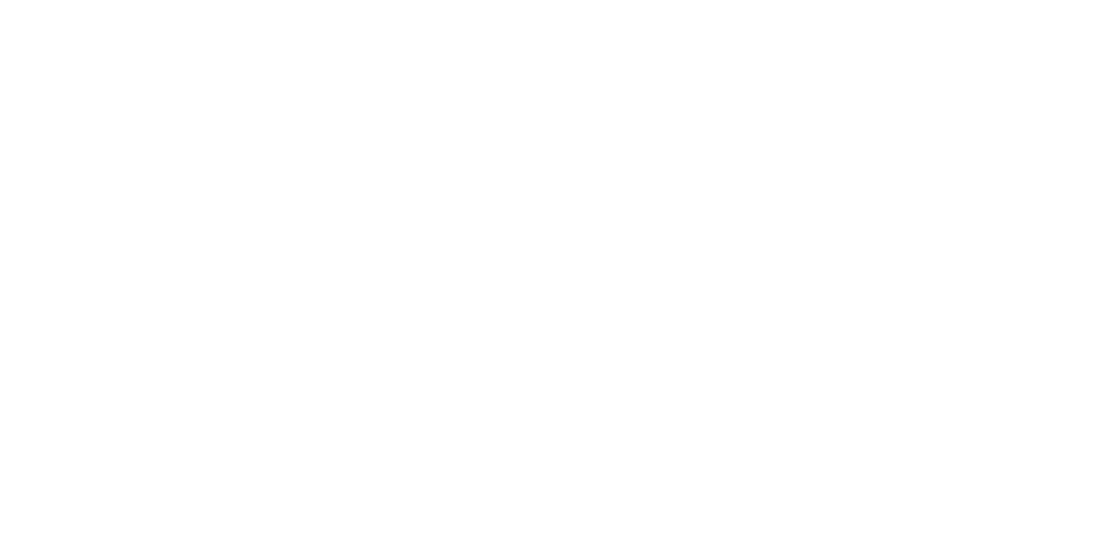

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


<IPython.core.display.Javascript object>


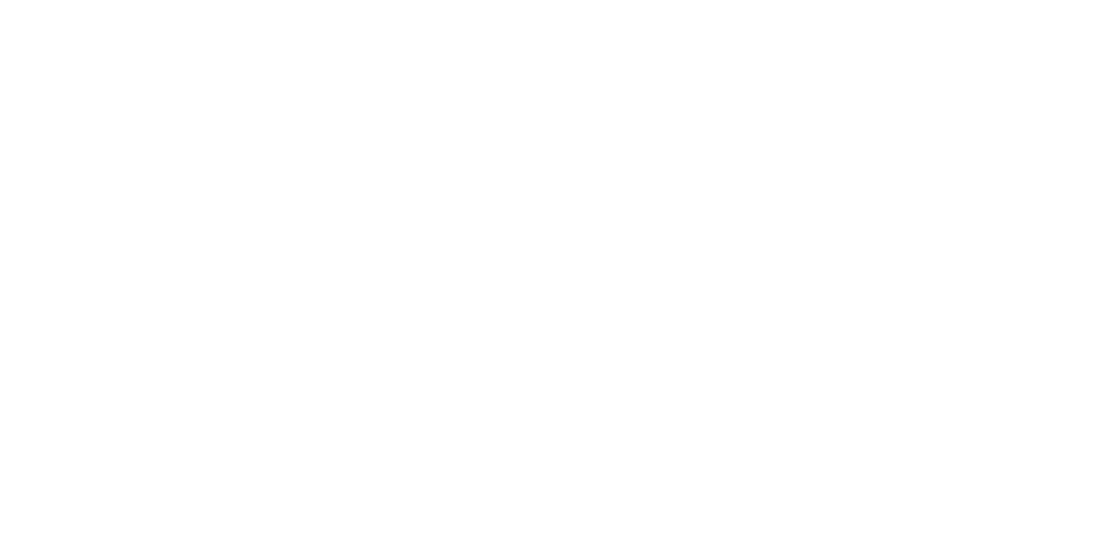

D1
M14
M27
M40
M53
M66
M79
M92
D2
control
here


In [49]:
for roi in rfs_gratings_rois:

    df[trace_type] = tracedf_blobs[roi]
    df.head()

    itercolors=iter(mpl.cm.cubehelix(np.linspace(0, .9, len(object_list)+1)))
    scale_bar = 0.1
    scale_bar2 = 0.2
    lw = 1
    markersize=2
    markeredgewidth = 0.2
    marker = 'o'
    fit_color = 'gray'
    tick_fontsize = 8
    axis_fontsize = 10
    tick_length = 2

    nr = 18 #len(object_list)
    nc = len(object_list)*2


    fig = pl.figure(figsize=(10, 5), facecolor='w')
    fig.patch.set_alpha(1)  # solution

    # 1. Plot RF map -----------------------------------------------------------
    rfmap_span = 8
    ax0 = pl.subplot2grid((nr, nc), (0, 0), rowspan=rfmap_span-2, colspan=rfmap_span)
    rfmap = rf_fits['fits'][roi]['data']
    rfim = ax0.imshow(rfmap, cmap='bone', vmin=0, vmax=rfmap.max(), \
                       origin='upper')
    ax0.axis('off')
    ax0.set_title('roi %i' % int(roi+1))
    # -- plot fit --
    amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f = rf_fits['fits'][roi]['fit_r']['popt']
    ell = Ellipse((x0_f, y0_f), abs(sigx_f)*sigma_scale, abs(sigy_f)*sigma_scale,\
                      angle=np.rad2deg(theta_f), alpha=1, edgecolor=fit_color, lw=1.5,\
                      facecolor='none')
    ax0.add_patch(ell)
    ax0.invert_yaxis()
    # -- colorbar --
    ax0_div = make_axes_locatable(ax0)
    cax0 = ax0_div.append_axes("right", size="2%", pad="2%")
    cb = colorbar(rfim, cax=cax0, orientation="vertical")
    cax0.yaxis.set_ticks_position("right")
    cax0.yaxis.set_tick_params(labelsize=tick_fontsize, length=0, width=0, pad=0.7)
    cax0.set_yticks([0, round(rfmap.max(), 1)])
    cax0.set_title('%s' % rf_fits['fit_params']['metric'], fontsize=axis_fontsize)


    # 2. Plot gratings traces -----------------------------------------------------------
    gratings_ix = rfmap_span
    g_rowspan = 3

    best_cfg = gdf.get_group(roi).groupby(['config']).mean()[metric_type].idxmax()
    best_cfg_params = gratings_params.loc[best_cfg][[p for p in params if p!='ori']]
    curr_cfgs = sorted([c for c in gratings_params.index.tolist() \
                        if all(gratings_params.loc[c][[p for p in params if p!='ori']] == best_cfg_params)],\
                        key = lambda x: gratings_params['ori'][x])
    gmean, gstd, gtsec = osi.get_mean_and_std_traces(roi, pd.DataFrame(gratings.data.traces), \
                                                    gratings.data.labels, \
                                                    curr_cfgs,\
                                                    gratings_params)
    g_stimon = gratings.data.labels['stim_on_frame'].unique()[0]
    g_nframes_on = gratings.data.labels['nframes_on'].unique()[0]
    ymin = (gmean - gstd ).min()
    ymax = (gmean + gstd ).max()
    for icfg in range(len(curr_cfgs)):
        ax = pl.subplot2grid((nr, nc), (0, icfg+gratings_ix), \
                             colspan=1, rowspan=g_rowspan) 
        if icfg==0:
            xoffset = 0
        else:
            xoffset = 0
        ax.plot(gtsec-xoffset, gmean[icfg, :], color='k', lw=lw)

        sem_plus = np.array(gmean[icfg,:]) + np.array(gstd[icfg,:])
        sem_minus = np.array(gmean[icfg,:]) - np.array(gstd[icfg,:])
        ax.fill_between(gtsec-xoffset, sem_plus, y2=sem_minus, alpha=0.2, color='k')

        # -- aesthetics --
        ax.set_xticks([]); ax.set_xticklabels([]);
        #ax.set_xticks([gtsec[g_stimon], round(gtsec[g_stimon+g_nframes_on], 1)])
        #ax.set_xticklabels(['%.2f s' % round(gtsec[g_stimon+g_nframes_on], 1), ''])
        ax.xaxis.set_tick_params(rotation=0, labelsize=tick_fontsize,\
                                 length=2, width=1, pad=0.7)
        ax.yaxis.set_tick_params(rotation=0, labelsize=tick_fontsize,\
                                 length=tick_length, width=1, pad=0.7)
        ax.set_yticks([gmean[0].mean(), gmean[0].mean()+scale_bar])
        ax.set_yticklabels(['', '%i%%\ndf/f' % (scale_bar*100)])
        ax.set_ylim([ymin, ymax])
        if icfg > 0:
            ax.set_yticks([]); ax.set_yticklabels([]);
            ax.set_xticks([]); ax.set_xticklabels([]);
            sns.despine(ax=ax, offset=4, trim=True, left=True, bottom=True)
        else:
            #ax.set_ylabel('%s' % trace_type, fontsize=6); #ax.set_xlabel('time (s)', fontsize=6);
            sns.despine(ax=ax, offset=4, trim=True, bottom=True)

    # 3. Plot tuning curve  -----------------------------------------------------------
    tested_oris = gratings.data.sdf['ori'].unique()
    meanr = gdf.get_group(roi).groupby(['config']).mean()[metric_type].loc[curr_cfgs]
    semr = gdf.get_group(roi).groupby(['config']).sem()[metric_type].loc[curr_cfgs]
    ax2 = pl.subplot2grid((nr, nc), (g_rowspan, gratings_ix), \
                              colspan=len(tested_oris), rowspan=g_rowspan)
    # -- plot raw
    ax2.plot(tested_oris, meanr, 'k', marker=marker,\
             markersize=markersize, markeredgewidth=markeredgewidth, lw=0)
    ax2.errorbar(tested_oris, meanr, yerr=semr, fmt='none', ecolor='k', elinewidth=1)
    # -- plot fit
    ax2.plot(tuning_fits[roi]['x'][0:-interp_interval], tuning_fits[roi]['fit_y'][0:-interp_interval], \
             c=fit_color, lw=lw)
    # -- aesthetics
    ax2.set_xticks(tested_oris)
    ax2.set_xticklabels([r'$\Uparrow$', r'$\Nearrow$', r'$\Rightarrow$', r'$\Searrow$',\
                        r'$\Downarrow$', r'$\Swarrow$', r'$\Leftarrow$', r'$\Nwarrow$'], color='k')

    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['', '1 stds'])
    sns.despine(ax=ax2, trim=True, offset=2, bottom=True)
    ax2.yaxis.set_tick_params(labelsize=tick_fontsize, rotation=90,
                              length=0, width=1, pad=0.7)
    ax2.xaxis.set_tick_params(labelsize=axis_fontsize, length=0, width=0)
    ax2.set_ylim([0, meanr.max()+semr.max()])


    # 2. Plot tuning curve polar fit -----------------------------------------------------------
    polar_ix = gratings_ix + len(tested_oris)
    axp = pl.subplot2grid((nr, nc), (0, polar_ix), polar=True,\
                          colspan=g_rowspan*2, rowspan=g_rowspan*2) #pl.subplots(1, 3) #pl.figure()
    interp_interval=3
    # -- plot raw
    thetas = np.array([np.deg2rad(c) for c in tuning_fits[roi]['x'][0::interp_interval]])
    radii = np.array(tuning_fits[roi]['y'][0::interp_interval])
    axp.plot(thetas, radii, 'k-', lw=lw)
    # -- plot fit
    thetas_fit = np.array([np.deg2rad(c) for c in tuning_fits[roi]['x']])
    radii_fit = np.array(tuning_fits[roi]['fit_y'])
    axp.plot(thetas_fit, radii_fit, lw=lw, c=fit_color)
    # -- aesthetics
    axp.set_theta_zero_location("N")
    axp.set_yticks([radii.min(), radii.max()])
    axp.set_yticklabels(['', round(radii.max(), 1)])
    axp.yaxis.set_tick_params(labelsize=tick_fontsize)
    axp.xaxis.set_tick_params(labelsize=axis_fontsize, pad=0.01)




    # 3. Plot object responses  -----------------------------------------------------------
    morph_ix=rfmap_span
    m_colspan=2
    m_rowspan=4

    # -- - plot images ---
    testim = cv2.imread(image_paths[0])
    img_dims = testim[:, :, 0].shape
    for mi, morphname in enumerate(object_list):
        print morphname
        if morphname == 'control':
            ax = pl.subplot2grid((nr, nc), (morph_ix, nc-m_colspan),colspan=m_colspan)
            ax.imshow(np.random.random(img_dims), cmap='gray')
        else:
            ax = pl.subplot2grid((nr, nc), (morph_ix, (mi*m_colspan)), colspan=m_colspan) #rowspan=1)
            img = cv2.imread(image_paths[mi])
            ax.imshow(img[:, :, 0], cmap='gray')    
        #ax.set_title(morphname, fontsize=axis_fontsize)#, fontsize=6)
        ax.set_xticks([]); ax.set_xticklabels([]);
        ax.set_yticks([]); ax.set_yticklabels([]);


    # -- - plot traces ---
    df[trace_type] = tracedf_blobs[roi]
    btraces = {}; btraces_sem ={};
    for cfg, g in df.groupby(['config']):
        btraces[cfg] = np.nanmean(np.array(list(g.groupby(['trial'])['dff'].apply(np.array))),\
                                  axis=0)
        btraces_sem[cfg] = stats.sem(np.array(list(g.groupby(['trial'])['dff'].apply(np.array))),\
                                  axis=0, nan_policy='omit')
        
    btraces = pd.DataFrame(btraces)
    btraces_sem = pd.DataFrame(btraces_sem)
    
    offset = (btraces.max().max() - btraces.min().min() )
    last_cfg = None
    last_morph=None
    curr_morph = None
    color = next(itercolors)
    aix=-1
    alpha=0.4
    nplots=0
    for ci, cfg in enumerate(btraces.columns):
        if ci > 0:
            curr_morph = blobs.data.sdf['morphlevel'][cfg]
            last_morph = blobs.data.sdf['morphlevel'][last_cfg]
        if last_morph != curr_morph:
            alpha = 0.4
            nplots = 0

        if blobs.data.sdf['morphlevel'][cfg] == -1:
            color = 'gray'
            if last_morph is None or last_morph != curr_morph:
                ax1 = pl.subplot2grid((nr, nc), ( morph_ix+1, nc-m_colspan),\
                                      rowspan=m_rowspan, colspan=m_colspan)
                #ax1.set_xticks([]); ax1.set_xticklabels([]);
                ax1.set_xticks([stim_on_frame]); ax1.set_xticklabels([r'$\bigtriangleup$']);
                ax1.xaxis.set_tick_params(labelsize=5, \
                                          length=0, width=0, pad=0.001)
                ax1.set_yticks([]); ax1.set_yticklabels([]);
                sns.despine(left=True, bottom=True, ax=ax1)
        else:
            if ci == 0 or curr_morph!=last_morph:
                aix += 1
                color = next(itercolors)
                ax1 = pl.subplot2grid((nr, nc), (morph_ix+1, (aix*m_colspan)),\
                                      rowspan=m_rowspan, colspan=m_colspan)
                if blobs.data.sdf['morphlevel'][cfg] == 0:
                    print('here')
                    ax1.set_xticks([stim_on_frame, stim_on_frame+round(fr*1.0)])
                    ax1.set_xticklabels(['1s', ''])
                    #ax1.set_xlabel('1s', fontsize=6, horizontalalignment='left')
                    miny = ax1.get_ylim()[0]+offset*6
                    ax1.set_yticks([miny, miny+scale_bar2])
                    ax1.set_yticklabels(['', '%i%%\ndf/f' % (scale_bar2*100)])
                    ax1.yaxis.set_tick_params(rotation=0, labelsize=tick_fontsize,\
                                              length=tick_length, width=1, pad=5)
                    ax1.xaxis.set_tick_params(rotation=0, labelsize=tick_fontsize,\
                                              length=tick_length, width=1, pad=0.7)

                    sns.despine(trim=True, ax=ax1)
                else:
                    ax1.set_xticks([stim_on_frame]);
                    ax1.set_xticklabels([r'$\bigtriangleup$']);
                    ax1.xaxis.set_tick_params(labelsize=5, \
                                              length=0, width=0, pad=0.001)
                    ax1.set_yticks([]); ax1.set_yticklabels([]);
                    sns.despine(left=True, ax=ax1, bottom=True) #, ax=ax1)

        alpha += (nplots*0.06)
        #print aix, alpha
        ax1.plot(btraces[cfg] + ci*offset, c=color, alpha=alpha, lw=1)
        sem_plus = np.array(btraces[cfg].values) + ci*offset + np.array(btraces_sem[cfg].values)
        sem_minus = np.array(btraces[cfg].values) + ci*offset - np.array(btraces_sem[cfg].values)
        ax1.fill_between(np.arange(0, len(btraces[cfg])), sem_plus, y2=sem_minus,
                         alpha=0.2, color=color)
        

            
        #ax1.text(0, btraces[cfg]+ci*offset, '%i' % blobs.data.sdf['size'][cfg])
        last_cfg = cfg
        nplots += 1

    #     ax1.spines['top'].set_visible(False)
    #     ax1.spines['right'].set_visible(False)
    #     ax1.spines['bottom'].set_visible(False)
    #     ax1.spines['left'].set_visible(False)
    pl.subplots_adjust(left=0.05, hspace=0.5, wspace=0.5, top=0.8, bottom=0.001, right=0.90)

    cax = pl.axes([0.92, 0.25, 0.005, 0.12])
    bounds = np.array(sizes[1:])+5
    bounds = sorted(np.append(bounds, 5))
    cmap = mpl.cm.gray
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(cax, cmap='gray_r',
                                    norm=norm,
                                    boundaries=bounds,
                                    ticks=np.array(bounds)-5,
                                    spacing='proportional',
                                    orientation='vertical')
    cb2.ax.yaxis.set_tick_params(length=0, labelsize=tick_fontsize, width=1, pad=0.7)
    cb2.ax.set_title('size', fontsize=axis_fontsize)
    
                         
    curr_data_id = '|'.join([animalid, session, fov, '\nrfs-%s' % rf_fit_str, '\ngratings-%s' % tuning_fit_str])
    label_figure(fig, curr_data_id)

    pl.savefig(os.path.join(roi_figdir, 'roi%05d_summary.png' % int(roi+1)),\
              transparent=False, facecolor='w', frameon=True)

    pl.close()


In [95]:
alpha

1.0

In [280]:
tuning_fits[roi].keys()

['mean_responses',
 'success',
 'r2',
 'oris',
 'fit_y',
 'offset',
 'pcov',
 'init',
 'popt',
 'y',
 'x',
 'configs']

In [124]:
cfg

'config050'

In [123]:
np.nanmean(mean_traces['config001'])

array([-3.30445151, -4.54980271, -4.11970125, -3.82684189, -4.0824129 ,
       -3.22574887, -2.97849303, -3.5152635 , -4.37333612, -3.44478697,
       -3.0603522 , -3.963834  , -2.938312  , -3.98172691, -3.69535396,
       -3.17715931, -3.07161198, -3.05060811, -3.51542589, -4.31123268,
       -2.73291928, -3.43199274, -2.88163774, -3.48404439, -2.74313931,
       -3.03944857, -3.87208621, -3.50477954, -3.69758107, -3.07611415,
       -3.72213702, -3.08849903, -3.25403648, -3.0067354 , -3.74537316,
       -2.88996713, -2.9355572 , -3.79793023, -2.38801908, -2.92591218,
       -2.78488904, -2.35663291, -2.38745292, -3.86947479, -3.82526291,
       -2.12614105, -4.08013538, -2.56930323, -2.96308447, -2.78707877,
       -2.58092487, -3.24081467, -2.59876823, -4.22855557, -4.06425351,
       -3.65624193, -3.9636571 , -2.83725921, -2.61198459, -3.63562541,
       -3.52658095, -3.61747412, -3.21062584, -2.79126398, -3.48300513,
       -2.41148161, -2.82502438, -4.21735334, -4.3566828 , -3.63

In [196]:

tuning_fits[roi]['x'][0::3]

[0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0, 360.0]

In [194]:
tuning_fits[roi]['y'][0::3]

[1.2449158902163537,
 2.5914646456652877,
 1.5365830985235869,
 1.3281541881728625,
 1.1933709635833938,
 1.4925301509658597,
 1.0381244027158028,
 1.1331981463541867,
 1.2449158902163537]

In [189]:
tuning_fits[roi]['mean_responses']

array([ 1.24491589,  2.59146465,  1.5365831 ,  1.32815419,  1.19337096,
        1.49253015,  1.0381244 ,  1.13319815])

<IPython.core.display.Javascript object>


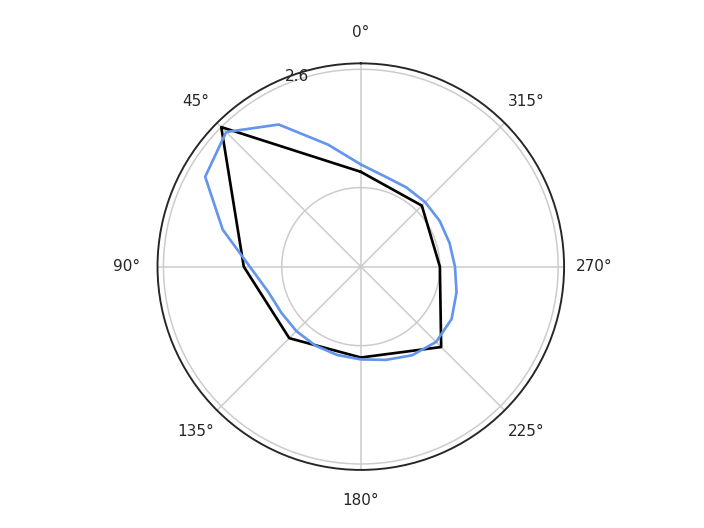

[Text(0,0,u''), Text(0,0,u'2.6')]

In [207]:
roi = 17
pl.figure()
axp = pl.subplot2grid((2, 2), (0, 0), colspan=2, rowspan=2, polar=True) #pl.subplots(1, 3) #pl.figure()
interp_interval=3

#thetas = np.array([np.deg2rad(c) for c in tuning_fits[roi]['x']])
#radii = osi.double_gaussian( thetas, *tuning_fits[roi]['popt'])


thetas = np.array([np.deg2rad(c) for c in tuning_fits[roi]['x'][0::interp_interval]])
radii = np.array(tuning_fits[roi]['y'][0::interp_interval])
thetas_fit = np.array([np.deg2rad(c) for c in tuning_fits[roi]['x']])
radii_fit = np.array(tuning_fits[roi]['fit_y'])
axp.plot(thetas, radii, 'k-')
axp.plot(thetas_fit, radii_fit, 'cornflowerblue')
axp.set_theta_zero_location("N")
axp.set_yticks([radii.min(), radii.max()])
axp.set_yticklabels(['', round(radii.max(), 1)])


<IPython.core.display.Javascript object>


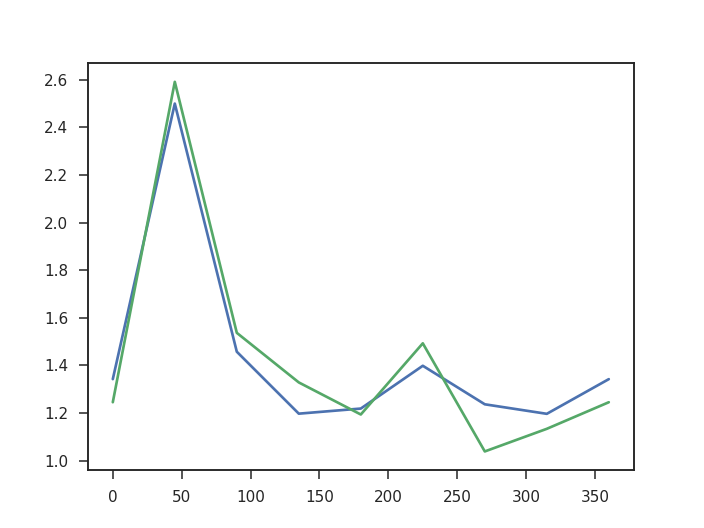

In [198]:
pl.figure()
pl.plot(tuning_fits[roi]['x'][0::3], tuning_fits[roi]['fit_y'][0::3])
pl.plot(tuning_fits[roi]['x'][0::3], tuning_fits[roi]['y'][0::3])

In [101]:
x.mean()

(179,)

In [ ]:
#gdf = resp.group_roidata_stimresponse(raw_traces.values, labels) # Each group is roi's trials x metrics
gdf = resp.get_roi_response_by_trial(raw_traces.values, labels)
#gratings_df_by_rois.get_group(roi_list[0])
nrois_total = len(gdf.groups)
